In [6]:
import os
import sys
sys.path.append('../')
import numpy as np
import numpy.linalg as la
import pickle
import scipy.io as sio
from scipy.stats import pearsonr
import pandas as pd
from functions.plot_funcs import *
from functions.aux_funcs import *
from tlviz.factor_tools import *
import tensorly as tl
from tensorly import cp_normalize
from tensorly.decomposition import parafac, constrained_parafac, parafac2
from matcouply.decomposition import cmf_aoadmm, initialize_cmf
from tensorly.metrics import congruence_coefficient
from tensorly.cp_tensor import *
from tensorly import backend as T
from matplotlib import rc, ticker
from natsort import natsort_keygen
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
import matplotlib.gridspec as gridspec
from matplotlib.transforms import ScaledTranslation
from copy import deepcopy

%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
fp = os.getcwd()

# Simulated data

## Construct ground truth factors

In [7]:
J = 36 # n taxa
I = 21 # n time points
K = 12 # n subjects

x = np.linspace(0, 1, 21) # time ponts
p = [6,6,6,3,3.5,4,7,7.5,8,6,6,6]

# taxa factor
A = np.array([[2,2,2,2,2,2,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
              [0,0,0,0,0,0,0,0,0,1,1,1,2,2,2,2,2,2,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
              [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,2,2,2,2,2,2,0,0,0,0,0,0]]).T

# subject factor
C = np.array([[1,1,0.01,0.01,0.01,1,1,0.01,0.01,0.01,1,1],
              [0.01,0.01,0.01,1,1,1,1,1,1,0.01,0.01,0.01],
              [0.01,0.01,0.01,0.01,0.01,0.01,1,1,1,1,1,1]]).T

# normalize A and C
A = A / la.norm(A, axis=0)
C = C / la.norm(C, axis=0)

B_0 = [pattern1(x) for k in range(K)]
B_1 = [pattern2(x,k) for k in p]
B_2 = [pattern3(x) for k in range(K)]

B_0 = list(np.asarray(B_0))
B_1 = list(np.asarray(B_1))
B_2 = list(np.asarray(B_2))

# # time factor
avgnorm = [la.norm(np.asarray([B_0[k],B_1[k],B_2[k]]).T,axis=0) for k in range(K)] # calculate the average norm of the bk2 loadings (non-parafac2 data!)
normsB = np.asarray(avgnorm).mean(axis=0)

# normalize B
B_ = [np.asarray([
    B_0[k] / normsB[0],
    B_1[k] / normsB[1],
    B_2[k] / normsB[2]
]).T for k in range(K)]

B_ = list(B_)

fac = (np.ones(3), (C, A, np.asarray(B_)))

In [8]:
# hex color codes for subjects per component
s1 = ['#8da0cb','#8da0cb',
      '#d9d9d9','#d9d9d9','#d9d9d9',
      '#8da0cb',"#aab9de",
      '#d9d9d9','#d9d9d9','#d9d9d9',
      '#8da0cb','#8da0cb']

s2 = ['#d9d9d9','#d9d9d9','#d9d9d9',
      '#bfd3e6','#9ebcda','#8c96c6','#8c6bb1','#88419d','#6e016b',
      '#d9d9d9','#d9d9d9','#d9d9d9']

s3 = ['#d9d9d9','#d9d9d9','#d9d9d9','#d9d9d9','#d9d9d9','#d9d9d9',
      '#8da0cb','#8da0cb','#8da0cb','#8da0cb','#8da0cb','#8da0cb']

# linestyles for subjects per component
l1 = ['dashed','dashed',
      'solid','solid','solid',
      'dashed','dashed',
      'solid','solid','solid',
      'dashed','dashed']

l2 = ['solid']*3 + ['dashed']*6 + ['solid']*3

l3 = ['solid']*6 + ['dashed']*6

# legend IDs for subjects per component
id1 = ["{1, 2, 6, 7, 11, 12}"]*2 + ["{3, 4, 5, 8, 9, 10}"]*3 + ["{1, 2, 6, 7, 11, 12}"]*2 + ["{3, 4, 5, 8, 9, 10}"]*3 + ["{1, 2, 6, 7, 11, 12}"]*2
id2 = ["{1, 2, 3, 10, 11, 12}"]*3 + ["4","5","6","7","8","9"] + ["{1, 2, 3, 10, 11, 12}"]*3 
id3 = ["{1, 2, 3, 4, 5, 6}"]*6 + ["{7, 8, 9, 10, 11, 12}"]*6

subject_colors = [s1,s2,s3]
linestyles = [l1,l2,l3]
subject_ids = [id1,id2,id3]

## Create data tensor from factors and optionally add noise

In [9]:
tensor = np.einsum(
    "ir,ijr,kr->ijk", C, B_, A
)
tensor = norm_tensor(tensor)

eta = 0 # control noise level; change to 0.25 to reproduce Fig S2
noise = np.random.normal(0, 1, tensor.shape)
noisy = tensor + tl.norm(tensor) * eta * noise / tl.norm(noise)

## Fit CP model

In [10]:
(_, (est_C, est_B, est_A)), errors = parafac(noisy, rank = 3,
                          init = 'random',
                          cvg_criterion = 'rec_error',
                          tol = 1e-8,
                          n_iter_max = 2000,
                          return_errors = True,
                          normalize_factors = True,
                          random_state = 1,
                          verbose = 0,
                          linesearch=True)

In [11]:
scaledB = np.empty((C.shape[0],B_[0].shape[0],C.shape[1]),dtype='float64')
est_scaledB = scaledB.copy()
for r in range(C.shape[1]):
    for k in range(C.shape[0]):
        scaledB[k,:,r] = C[k,r] * np.asarray(B_)[k,:,r]
        est_scaledB[k,:,r] = est_C[k,r] * np.asarray(est_B)[:,r]
        
fac_ = (np.ones(3), (A, np.vstack(scaledB)))
est = (np.ones(3), (est_A, np.vstack(est_scaledB)))
(fms, p) = factor_match_score(fac_,est,consider_weights=False, return_permutation=True)
est_cp = (np.asarray(np.ones(3)), (est_C[:,p], est_A[:,p], est_B[:,p]))

print("FMS = ", fms)
print("Fit = ", reconstructed_variance((_, (est_C, est_B, est_A)), noisy)*100)

FMS =  0.993922791067539
Fit =  98.91003154976023


## Fit PARAFAC2 model

In [12]:
best_err = np.inf
decomposition = None

repro_df = []

noisy = noisy/tl.norm(noisy)
for run in range(10):
    trial_decomposition, trial_errs = parafac2(
        noisy,
        3,
        nn_modes=[0],
        return_errors=True,
        tol=1e-8,
        n_iter_max=500,
        normalize_factors=True,
        verbose=0,
        random_state=run
    )
    est_weights, (est_C, est_B, est_A) = tl.parafac2_tensor.apply_parafac2_projections(trial_decomposition)
    repro_df.append({"fac": (est_C, est_B, est_A), "fval": trial_errs[-1]})

    if best_err > trial_errs[-1]:
        best_err = trial_errs[-1]
        err = trial_errs
        decomposition = trial_decomposition

    est_tensor = tl.parafac2_tensor.parafac2_to_tensor(decomposition)
    est_weights, (est_C, est_B, est_A) = tl.parafac2_tensor.apply_parafac2_projections(
        decomposition
    )

scaledB = np.empty((C.shape[0],B_[0].shape[0],C.shape[1]),dtype='float64')
est_scaledB = scaledB.copy()
for r in range(C.shape[1]):
    for k in range(C.shape[0]):
        scaledB[k,:,r] = C[k,r] * np.asarray(B_)[k,:,r]
        est_scaledB[k,:,r] = est_C[k,r] * np.asarray(est_B)[k,:,r]

fac_ = (np.asarray(np.ones(3)), (C, np.vstack(scaledB)))
est = (np.asarray(np.ones(3)), (est_C, np.vstack(est_scaledB)))

(fms, p) = factor_match_score(fac_,est,consider_weights=False, return_permutation=True)
est_par2 = (np.asarray(np.ones(3)), (est_C[:,p], est_A[:,p], np.asarray(est_B)[:,:,p]))

print("FMS = ", fms)
reconstruction_error = la.norm(est_tensor - noisy)**2
recovery_rate = 1 - reconstruction_error / la.norm(noisy)**2
print("Fit = ", recovery_rate*100)


FMS =  0.9965280347520368
Fit =  99.91096178163652


In [13]:
##  compute scaled time loadings for ground truth, CP and PARAFAC2
A = fac[1][1]
Acp = est_cp[1][1]
Apar2 = est_par2[1][1]

scaledB = np.empty((fac[1][0].shape[0],fac[1][2].shape[1],fac[1][0].shape[1]),dtype='float64')
scaledBcp = scaledB.copy()
scaledBpar2 = scaledB.copy()
for r in range(fac[1][0].shape[1]):
    for k in range(fac[1][0].shape[0]):
        scaledB[k,:,r] = fac[1][0][k,r] * np.asarray(fac[1][2])[k,:,r]
        scaledBcp[k,:,r] = est_cp[1][0][k,r] * np.asarray(est_cp[1][2])[:,r]
        scaledBpar2[k,:,r] = est_par2[1][0][k,r] * np.asarray(est_par2[1][2])[k,:,r]

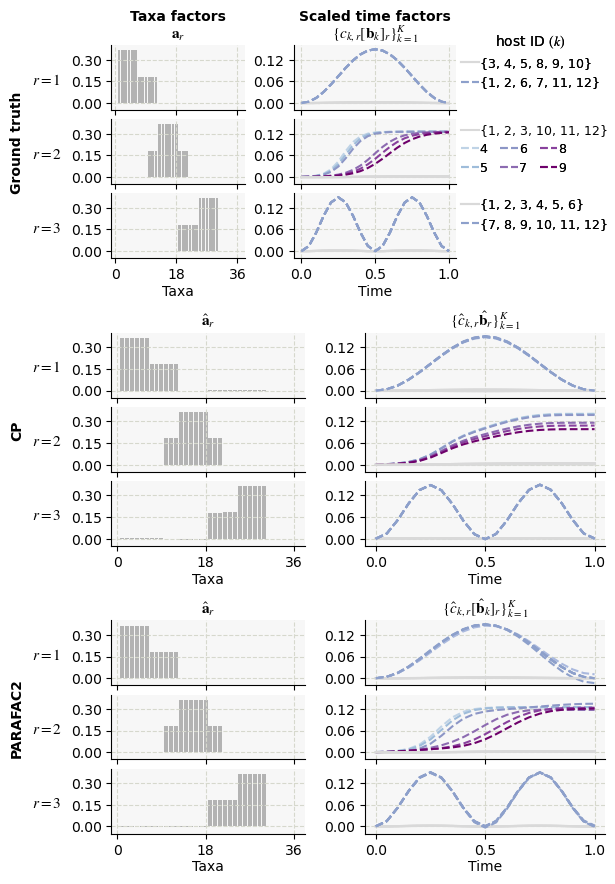

In [14]:
##  Fig 2 / Fig S1 if eta = 0.25
fig2 = get_fig2([A,scaledB],[Acp,scaledBcp],[Apar2,scaledBpar2],subject_colors,linestyles, subject_ids)
fig2.savefig('analysis_results/figures/Fig2.png',dpi=600,bbox_inches='tight',pad_inches=0.05)

# COPSAC2010 gut

## Model selection

In [11]:
## collect model fit and replicability (FMS) results by number of components
## uncomment if 1_fit_model.sh was run, otherwise reads in the saved results

# Fit_by_R = collect_fit(fp,"COPSAC2010","cp")
# FMS_by_R = collect_replicability_results("COPSAC2010", "cp")
# Fit_by_R = collect_fit(fp,"COPSAC2010","parafac2")
# FMS_by_R = collect_replicability_results("COPSAC2010", "parafac2")  

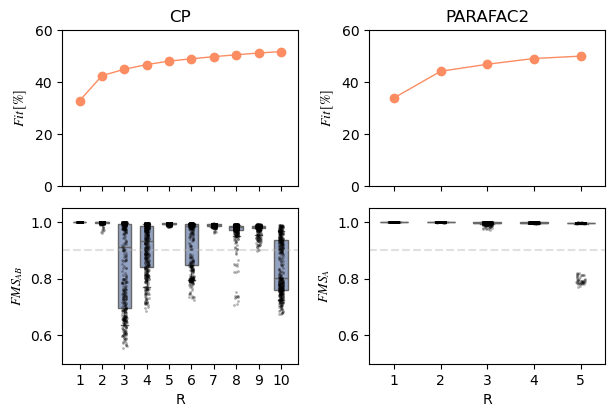

In [15]:
##  Fig S2

figS2 = plt.figure(figsize=mm2inch((178,110)))

gs = gridspec.GridSpec(1,2, figure=figS2, wspace=0.3)
gs0 = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=gs[0], height_ratios=(0.5,0.5), wspace=0.3, hspace=0.14)
gs1 = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=gs[1], height_ratios=(0.5,0.5), wspace=0.3, hspace=0.14)

axs0 = gs0.subplots(sharex=True)
axs1 = gs1.subplots(sharex=True)

fit_rep_plot("COPSAC2010", "cp", axs0)
fit_rep_plot("COPSAC2010", "parafac2", axs1)

figS2.savefig('analysis_results/figures/FigS2.png',dpi=600,bbox_inches='tight')
plt.show()

## CP, R=7

In [ ]:
##  load data, metadata
# with open(fp+'/data/COPSAC2010_data.pkl', 'rb') as f:
#     Data = pickle.load(f)
# tensor, sub_id, tax_id = filter_data(Data, n_time=0, f_threshold=0.1)
# Metadata = pd.read_csv(fp+'/data/COPSAC2010_metadata.csv')
# Taxonomy = pd.read_table(fp+'/data/COPSAC2010_taxonomy.tsv',sep=',')
# strat_var = "Delivery mode"

# tensor = clr(tensor.astype(np.float32))
# mask = np.isfinite(tensor)
# tensor = norm_tensor(tensor)

# with open(fp+'/data/tax_colormap_copsac.p', 'rb') as f:
#     tax_colormap_copsac = pickle.load(f)

# for key, value in tax_colormap_copsac.copy().items():
#     if "Family" in key:
#        new_str = key.replace("Family","f_")
#        tax_colormap_copsac[new_str] = tax_colormap_copsac.pop(key)

time_labels = ["1wk", "1mth", "1yr", "4yr", "6yr"]

##  load model
model_ = pd.read_pickle(fp+"/analysis_results/models/COPSAC2010/cp/R7/best_run.pkl")
model = model_.loc['factors']

weights, (C,B,A) = model

##  permute to decreasing order of component weights
p = np.argsort(-la.norm(C, axis=0))

C = C[:,p]
C = C / la.norm(C, axis=0)  # normalize C_par2
B = B[:,p]
A = A[:,p]

##  FIT
# print("Fit = ", reconstructed_variance(model, tensor)*100)

Fit =  49.83775018486429


### Factor plot

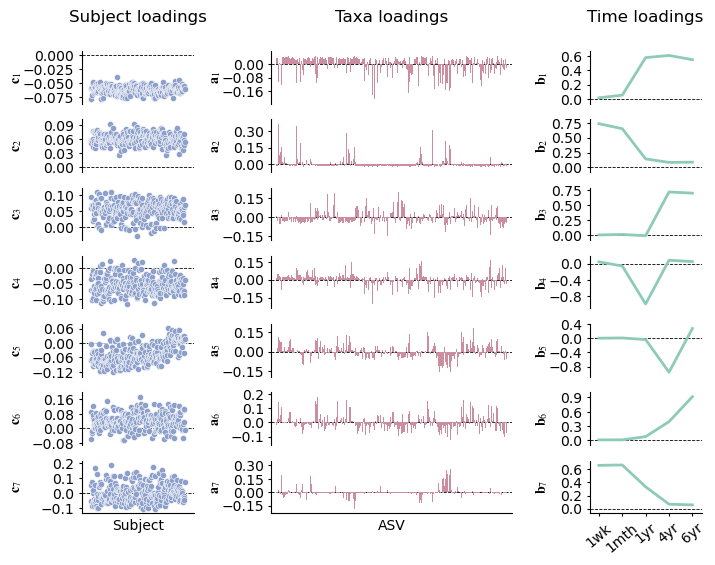

In [24]:
##  Fig S3
C[:,1] = C[:,1] * -1 # sign ambiguity
A[:,1] = A[:,1] * -1

figS3 = factorplot([C,A,np.asarray(B)], var=None, Metadata=None, time_labels=time_labels, splines_on=False, nometa=True)
plt.show()
figS3.savefig("analysis_results/figures/FigS3.png", bbox_inches='tight', dpi=600)

(7,) (5, 7)
(7,) (5, 7)
vaginal, no vs. vaginal, yes: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:1.858e-02 U_stat=3.588e+03
vaginal, yes vs. c-section, yes: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:5.045e-01 U_stat=5.890e+02
vaginal, no vs. c-section, yes: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:4.182e-01 U_stat=5.340e+03
vaginal, no vs. vaginal, yes: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:1.144e-01 U_stat=3.379e+03
vaginal, yes vs. c-section, yes: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:3.348e-02 U_stat=9.750e+02
vaginal, no vs. c-section, yes: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:1.827e-09 U_stat=7.378e+03
(7,) (5, 7)


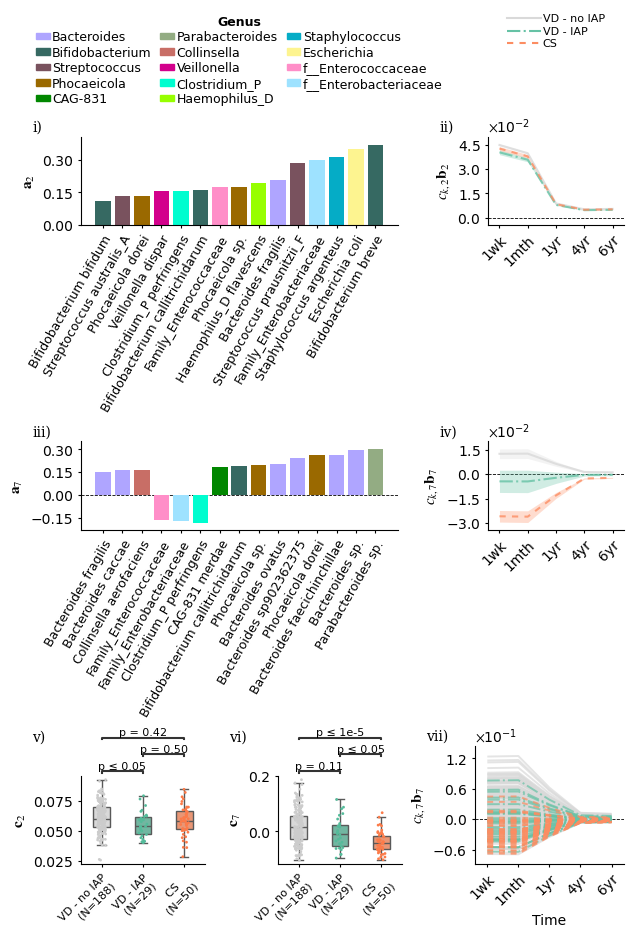

In [ ]:
##  Fig S5

# figS5 = plt.figure(figsize=mm2inch((178,240)))

# gs = gridspec.GridSpec(3,1, figure=figS5, hspace=2.2, height_ratios=(0.3,0.3,0.4))
# gs0 = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gs[0], width_ratios=(0.7,0.3), wspace=0.4, hspace=0.18)
# gs1 = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gs[1], width_ratios=(0.7,0.3), wspace=0.4, hspace=0.18)
# gs2 = gridspec.GridSpecFromSubplotSpec(1, 3, subplot_spec=gs[2], width_ratios=(0.3,0.3,0.36), wspace=0.55, hspace=0.4)

# axs0 = gs0.subplots()
# axs1 = gs1.subplots()
# axs2 = gs2.subplots()

# taxaplot(axs0[0],[C,A,np.asarray(B)], 
#          Taxonomy, 2, labels=False, subtitle=False, 
#          legend=True, tax_abbrev=False, legtitleheight=2.5,nspec = 15,
#          multcomptaxa=(2,7), tax_col=tax_colormap_copsac)
# fnscaledtimeplot(axs0[1],[C,A,np.asarray(B)], 
#                       Metadata, 2, ['Delivery mode','Antibiotics'], 
#                       time_labels=time_labels, individual=False, err="SEM",
#                       subtitle=False, labels=False, legend=True, legtitleheight=2.5)

# taxaplot(axs1[0],[C,A,np.asarray(B)], 
#          Taxonomy, 7, labels=False, subtitle=False, 
#          legend=False, tax_abbrev=False, legtitleheight=1.35,nspec = 15,
#          multcomptaxa=(2,7), tax_col=tax_colormap_copsac)
# fnscaledtimeplot(axs1[1],[C,A,np.asarray(B)], 
#                       Metadata, 7, ['Delivery mode','Antibiotics'], 
#                       time_labels=time_labels, individual=False, err="SEM",
#                       subtitle=False, labels=False, legend=False, legtitleheight=1.3)

# subjectsplot(axs2[0], [C,A,np.asarray(B)], Metadata, 2)
# subjectsplot(axs2[1], [C,A,np.asarray(B)], Metadata, 7)
# fnscaledtimeplot(axs2[2],[C,A,np.asarray(B)], 
#                       Metadata, 7, ['Delivery mode','Antibiotics'], 
#                       time_labels=time_labels, individual=True, 
#                       subtitle=False, labels=True, legend=False, legtitleheight=1.3,ylabshift=-0.14)

# for ax in [axs2[0], axs2[1]]:
#     box = ax.get_position()
#     new_position = [box.x0, box.y0, box.width, box.height * 0.75]
#     ax.set_position(new_position)

# # panel labels
# labels = ['i)', 'ii)', 'iii)', 'iv)', 'v)', 'vi)', 'vii)']
# for ix, ax in enumerate([axs0[0], axs0[1], axs1[0], axs1[1], axs2[0], axs2[1], axs2[2]]):
#     if ix in [4,5]:
#         ax.annotate(
#             labels[ix],
#             xy=(0, 1.33), xycoords='axes fraction',
#             xytext=(-3.5, 0.2), textcoords='offset fontsize', fontsize='medium', va='bottom', fontfamily='serif')
#     else:
#         ax.annotate(
#             labels[ix],
#             xy=(0, 1), xycoords='axes fraction',
#             xytext=(-3.5, 0.2), textcoords='offset fontsize', fontsize='medium', va='bottom', fontfamily='serif')

# plt.savefig("analysis_results/figures/FigS5.png",dpi=600, bbox_inches='tight',pad_inches=0.03)
# plt.show()

## PARAFAC2, R=5

In [ ]:
##  load model
model_par2 = pd.read_pickle(fp+"/analysis_results/models/COPSAC2010/parafac2/R5/best_run.pkl")
(C_par2,B_par2,A_par2) = model_par2.loc["factors"]

##  permute to decreasing order of component weights
p = np.argsort(-la.norm(C_par2, axis=0))

C_par2 = C_par2[:,p]
C_par2 = C_par2 / la.norm(C_par2, axis=0)  # normalize C_par2
B_par2 = np.asarray(B_par2)[:,:,p]
A_par2 = A_par2[:,p]
# print("Fit = ", get_model_fit(model_par2.loc['factors'], tensor, mask))

Fit =  50.036017257786746


In [28]:
##  check convergence
# reconstruction_error = np.asarray([err for err in model_par2.loc["rec_errors"]]).reshape(-1,1)
# feasibility_gaps = np.asarray([err for err in model_par2.loc["feasibility_gaps"]])

# fig, axs = plt.subplots(1,3, figsize=(7,3))
# errs = np.hstack((reconstruction_error, feasibility_gaps))
# titles = ["relative reconstruction error", "parafac2 feasibility", "nonnegativity C feasibility"]
# for ix, ax in enumerate(range(errs.shape[1])):
#     axs[ix].semilogy(errs[:,ix])
#     axs[ix].set_title(titles[ix])
#     if ix == 0:
#         axs[ix].set_ylim((0.2, 0.5))

# plt.tight_layout()
# axs[1].set_xlabel("iteration")
# plt.minorticks_off()
# plt.show()

### Scaled factor plot

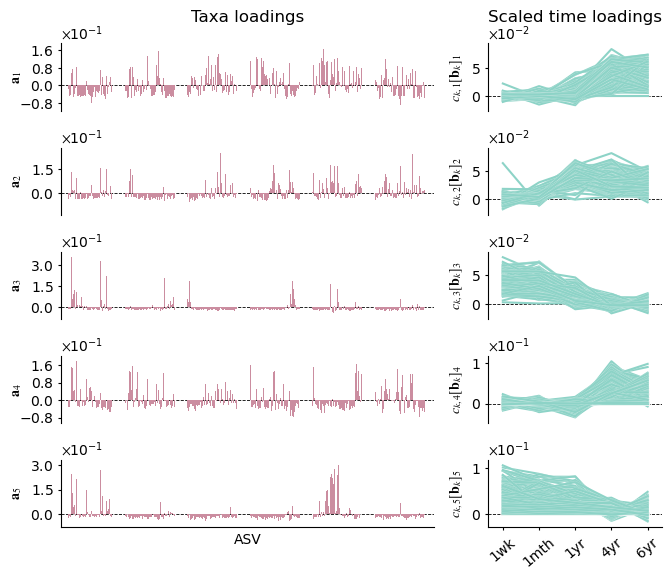

In [29]:
##  Fig S4

figS4 = scaledfactorplot_plain([C_par2,A_par2,B_par2], time_labels=time_labels)

figS4.savefig("analysis_results/figures/FigS4.png", bbox_inches='tight', dpi=600)
figS4.tight_layout()
plt.show()

### PARAFAC2 -- delivery mode/antibiotics

(5,) (267, 5, 5)
(5,) (267, 5, 5)
vaginal, no vs. vaginal, yes: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:1.000e+00 U_stat=2.857e+03
vaginal, yes vs. c-section, yes: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:1.837e-02 U_stat=4.550e+02
vaginal, no vs. c-section, yes: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:9.309e-04 U_stat=3.139e+03
vaginal, no vs. vaginal, yes: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:2.186e-01 U_stat=3.291e+03
vaginal, yes vs. c-section, yes: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:3.348e-02 U_stat=9.750e+02
vaginal, no vs. c-section, yes: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:1.286e-07 U_stat=7.071e+03
(5,) (267, 5, 5)


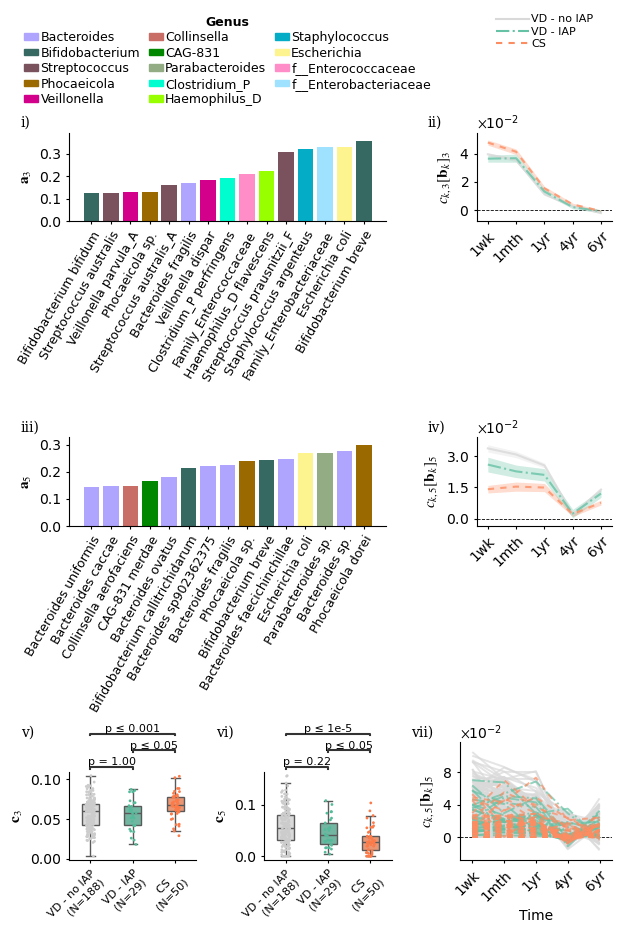

In [ ]:
# Fig 3

# fig3 = plt.figure(figsize=mm2inch((178,240)))

# gs = gridspec.GridSpec(3,1, figure=fig3, hspace=2.2, height_ratios=(0.3,0.3,0.4))
# gs0 = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gs[0], width_ratios=(0.7,0.3), wspace=0.4, hspace=0.18)
# gs1 = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gs[1], width_ratios=(0.7,0.3), wspace=0.4, hspace=0.18)
# gs2 = gridspec.GridSpecFromSubplotSpec(1, 3, subplot_spec=gs[2], width_ratios=(0.3,0.3,0.36), wspace=0.5, hspace=0.18)

# axs0 = gs0.subplots()
# axs1 = gs1.subplots()
# axs2 = gs2.subplots()

# taxaplot(axs0[0],[C_par2,A_par2,B_par2], 
#          Taxonomy, 3, labels=False, subtitle=False, 
#          legend=True, tax_abbrev=False, legtitleheight=2.45,nspec = 15,
#          multcomptaxa=(3,5), tax_col=tax_colormap_copsac)
# fnscaledtimeplot(axs0[1],[C_par2,A_par2,B_par2], 
#                       Metadata, 3, ['Delivery mode','Antibiotics'], 
#                       time_labels=time_labels, individual=False, err="SEM",
#                       subtitle=False, labels=False, legend=True, legtitleheight=2.45)

# taxaplot(axs1[0],[C_par2,A_par2,B_par2], 
#          Taxonomy, 5, labels=False, subtitle=False, 
#          legend=False, tax_abbrev=False, legtitleheight=1.35,nspec = 15,
#          multcomptaxa=(3,5), tax_col=tax_colormap_copsac)
# fnscaledtimeplot(axs1[1],[C_par2,A_par2,B_par2], 
#                       Metadata, 5, ['Delivery mode','Antibiotics'], 
#                       time_labels=time_labels, individual=False, err="SEM",
#                       subtitle=False, labels=False, legend=False, legtitleheight=1.3)

# subjectsplot(axs2[0], [C_par2,A_par2,B_par2], Metadata, 3)
# subjectsplot(axs2[1], [C_par2,A_par2,B_par2], Metadata, 5)

# fnscaledtimeplot(axs2[2],[C_par2,A_par2,B_par2], 
#                       Metadata, 5, ['Delivery mode','Antibiotics'], 
#                       time_labels=time_labels, individual=True, 
#                       subtitle=False, labels=True, legend=False, legtitleheight=1.3,ylabshift=-0.12)

# # panel labels
# labels = ['i)', 'ii)', 'iii)', 'iv)', 'v)', 'vi)', 'vii)']
# for ix, ax in enumerate([axs0[0], axs0[1], axs1[0], axs1[1], axs2[0], axs2[1], axs2[2]]):
#     if ix in [4,5]:
#         ax.annotate(
#             labels[ix],
#             xy=(0, 1.33), xycoords='axes fraction',
#             xytext=(-3.5, 0.2), textcoords='offset fontsize', fontsize='medium', va='bottom', fontfamily='serif')
#     else:
#         ax.annotate(
#             labels[ix],
#             xy=(0, 1), xycoords='axes fraction',
#             xytext=(-3.5, 0.2), textcoords='offset fontsize', fontsize='medium', va='bottom', fontfamily='serif')

# for ax in [axs2[0], axs2[1]]:
#     box = ax.get_position()
#     new_position = [box.x0, box.y0, box.width, box.height * 0.75]
#     ax.set_position(new_position)

# plt.savefig("analysis_results/figures/Fig3.png",dpi=600, bbox_inches='tight',pad_inches=0.03)
# plt.show()

## Comparison of CP and PARAFAC2 top 15 taxa

In [22]:
taxa_CP_1 = set(np.argpartition(abs(A[:,1]), -15)[-15:])
taxa_PAR2_1 = set(np.argpartition(abs(A_par2[:,2]), -15)[-15:])
taxa_CP_2 = set(np.argpartition(abs(A[:,6]), -15)[-15:])
taxa_PAR2_2 = set(np.argpartition(abs(A_par2[:,4]), -15)[-15:])

print("ASV percentage of overlapping taxa in the top 15 features\n" \
"component 2 = ", len(taxa_CP_1 & taxa_PAR2_1)/15 * 100)

print("ASV percentage of overlapping taxa in the top 15 features\n" \
"component 7 = ", len(taxa_CP_2 & taxa_PAR2_2)/15 * 100)

# union 
taxa_CP = taxa_CP_1.union(taxa_CP_2)
taxa_PAR2 = taxa_PAR2_1.union(taxa_PAR2_2)

# ASV
denom3 = len(taxa_CP.union(taxa_PAR2))
print("ASV percentage of overlapping taxa in the top 15 features\n" \
"both components = ", len(taxa_CP & taxa_PAR2)/denom3 * 100)

ASV percentage of overlapping taxa in the top 15 features
component 2 =  86.66666666666667
ASV percentage of overlapping taxa in the top 15 features
component 7 =  80.0
ASV percentage of overlapping taxa in the top 15 features
both components =  88.46153846153845


## Replicability of PARAFAC2 scaled time loadings [COPSAC2010]

In [23]:
# load reference and alternative models
PAR2_A_ = pd.read_pickle(fp+"/analysis_results/models/COPSAC2010/parafac2/R5/best_run.pkl").loc['factors'] # reference
PAR2_B_ = pd.read_pickle(fp+"/analysis_results/models/COPSAC2010/parafac2/R5_alt_1/best_run.pkl").loc['factors'] # alternative 1 
PAR2_C_ = pd.read_pickle(fp+"/analysis_results/models/COPSAC2010/parafac2/R5_alt_2/best_run.pkl").loc['factors'] # alternative 2 


PAR2_A = ( 
    (np.array([1.0] * PAR2_A_[0].shape[1])),
    (PAR2_A_[0], np.vstack(PAR2_A_[1])) # C and B
)

PAR2_B = ( 
    (np.array([1.0] * PAR2_B_[0].shape[1])),
    (PAR2_B_[0], np.vstack(PAR2_B_[1])) # C and B
)

PAR2_C = ( 
    (np.array([1.0] * PAR2_C_[0].shape[1])),
    (PAR2_C_[0], np.vstack(PAR2_C_[1])) # C and B
)


H = factor_match_score(PAR2_A, PAR2_B, consider_weights=False, return_permutation=True)
H2 = factor_match_score(PAR2_A, PAR2_C, consider_weights=False, return_permutation=True)
print("FMS subject+time = {:1.0%}".format(factor_match_score(PAR2_A, PAR2_B, consider_weights=False)))
print("cosine similarty subjects = {:1.0%}".format(congruence_coefficient(PAR2_A[1][0],PAR2_B[1][0])[0]))
print("cosine similarty time = {:1.0%}".format(congruence_coefficient(PAR2_A[1][1],PAR2_B[1][1])[0]))

# get permuted PAR2_B
PAR2_B[1][0][:,:] = PAR2_B[1][0][:,H[1]]
PAR2_B[1][1][:,:] = PAR2_B[1][1][:,H[1]]

PAR2_C[1][0][:,:] = PAR2_C[1][0][:,H2[1]]
PAR2_C[1][1][:,:] = PAR2_C[1][1][:,H2[1]]

from numpy import dot
from numpy.linalg import norm
print("cosine similarity 10-20 comp5 time = {:1.0%}".format(dot(PAR2_A[1][1][:,4], PAR2_B[1][1][:,4])/(norm(PAR2_A[1][1][:,4])*norm(PAR2_B[1][1][:,4]))))
print("cosine similarity 10-30 comp5 time = {:1.0%}".format(dot(PAR2_A[1][1][:,4], PAR2_C[1][1][:,4])/(norm(PAR2_A[1][1][:,4])*norm(PAR2_C[1][1][:,4]))))


FMS subject+time = 100%
cosine similarty subjects = 100%
cosine similarty time = 100%
cosine similarity 10-20 comp5 time = 100%
cosine similarity 10-30 comp5 time = 99%


In [24]:
##  REF 10% filtering
C1 = PAR2_A[1][0]
C1 = C1 / la.norm(C1, axis=0)
B1 = np.asarray(PAR2_A[1][1].reshape(C1.shape[0], 5, C1.shape[1]))
A1 = PAR2_A_[2]
CB1 = np.empty((C1.shape[0],5,C1.shape[1]),dtype='float64')
for r in range(5):
    for k in range(267):
        CB1[k,:,r] = C1[k,r] * B1[k,:,r]

##  20% filtering
C2 = PAR2_B[1][0]
C2 = C2 / la.norm(C2, axis=0)
B2 = np.asarray(PAR2_B[1][1].reshape(C2.shape[0], 5, C2.shape[1]))
A2 = PAR2_B_[2]
CB2 = np.empty((C2.shape[0],5,C2.shape[1]),dtype='float64')
for r in range(5):
    for k in range(267):
        CB2[k,:,r] = C2[k,r] * B2[k,:,r]

##  30% filtering
C3 = PAR2_C[1][0]
C3 = C3 / la.norm(C3, axis=0)
B3 = np.asarray(PAR2_C[1][1].reshape(C3.shape[0], 5, C3.shape[1]))
A3 = PAR2_C_[2]
CB3 = np.empty((C3.shape[0],5,C3.shape[1]),dtype='float64')
for r in range(5):
    for k in range(267):
        CB3[k,:,r] = C3[k,r] * B3[k,:,r]

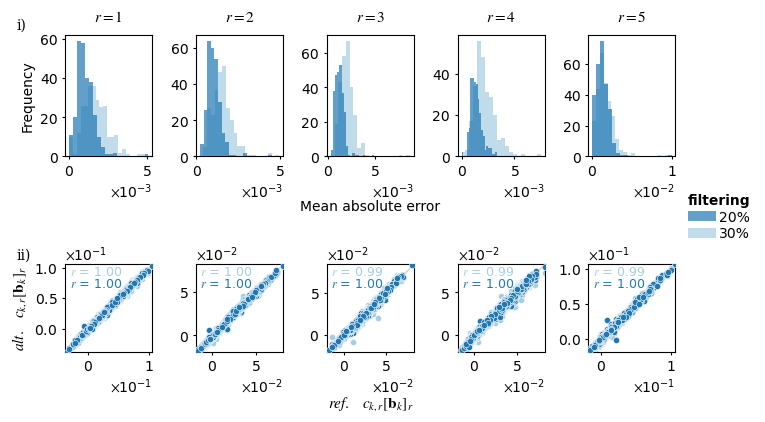

In [25]:
##  Fig S11
figS11 = get_figS11(CB1,CB2,CB3)
figS11.savefig("analysis_results/figures/FigS11.png",dpi=600, bbox_inches='tight')
plt.show()

In [26]:
max_ixs, min_ixs1, mae1 = topn_subj(CB1, CB2, 4, 3)
max_ixs2, min_ixs2, mae2 = topn_subj(CB1, CB3, 4, 3)
max_ixs = np.unique(np.concatenate((max_ixs, max_ixs2)))
print(max_ixs)

[ 17 119 195 208 259]


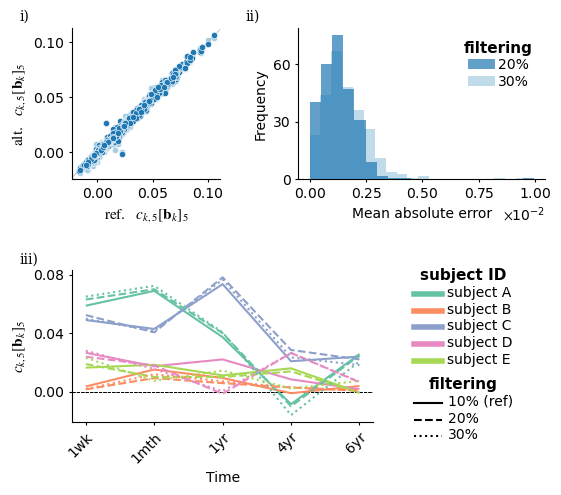

In [27]:
fig5 = get_fig5([C1,A1,B1],[C2,A2,B2],[C3,A3,B3], CB1, CB2, CB3, mae1, mae2, max_ixs)
fig5.savefig("analysis_results/figures/Fig5.png",dpi=600, bbox_inches='tight',pad_inches=0.03)
plt.show()

# FARMM data

## Model selection

In [28]:
## collect model fit and replicability (FMS) results by number of components
## uncomment if 1_fit_model.sh was run, otherwise reads in the saved results

# Fit_by_R = collect_fit(fp,"FARMM","cp")
# FMS_by_R = collect_replicability_results("FARMM", "cp")
# Fit_by_R = collect_fit(fp,"FARMM","parafac2")
# FMS_by_R = collect_replicability_results("FARMM", "parafac2")  

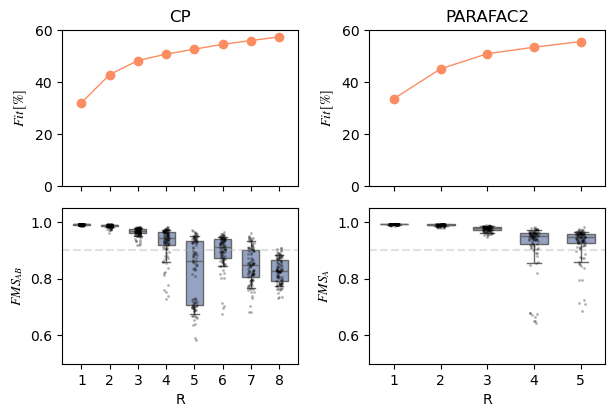

In [29]:
##  Fig S6

figS6 = plt.figure(figsize=mm2inch((178,110)))

gs = gridspec.GridSpec(1,2, figure=figS6, wspace=0.3)
gs0 = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=gs[0], height_ratios=(0.5,0.5), wspace=0.3, hspace=0.14)
gs1 = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=gs[1], height_ratios=(0.5,0.5), wspace=0.3, hspace=0.14)

axs0 = gs0.subplots(sharex=True)
axs1 = gs1.subplots(sharex=True)

fit_rep_plot("FARMM", "cp", axs0)
fit_rep_plot("FARMM", "parafac2", axs1)

figS6.savefig('analysis_results/figures/FigS6.png',dpi=600,bbox_inches='tight')
plt.show()

## CP, R=3

In [30]:
##  load data, metadata, and model

Data = np.load(fp+'/data/FARMM_data.npy')
Data = np.moveaxis(Data, -1, -2).T # subjects by time by taxa
tensor = np.delete(Data, 0, axis=1)
from functions.aux_funcs import percentage_nan
print("Percentage of missing entries: ",percentage_nan(tensor))
time_labels = list(range(1,16))
Metadata = pd.read_csv(fp+'/data/FARMM_metadata.csv', index_col=[0])
Metadata.rename(columns={"study_group": "Study group"}, inplace=True)
Metadata = Metadata.groupby('SubjectID').agg({
    'study_day': 'first',
    'Study group': 'first'
})
Metadata["Study group"] = pd.Categorical(Metadata['Study group'], ordered=True, categories=["Vegan", "Omnivore", "EEN"])
Farmmtaxa = pd.read_csv(fp+'/data/FARMM_data_taxonomy.csv')
Taxonomy = Farmmtaxa['x'].str.split("|", expand=True)
Taxonomy.columns = ["Domain", "Phylum", "Class", "Order", "Family", "Genus", "Species"]
Taxonomy['Species'] = Taxonomy['Species'].fillna(Taxonomy['Genus'])
Taxonomy["Genus"] = Taxonomy["Genus"].str.replace("g__","",regex=True) # for more concise plots
Taxonomy["Species"] = Taxonomy["Species"].str.replace("s__","",regex=True) # for more concise plots
Taxonomy["Species"] = Taxonomy["Species"].str.replace("_"," ",1) # for more concise plots
Taxonomy.loc[Taxonomy["Family"].str.contains("noname"),"Family"] = Taxonomy.loc[Taxonomy["Family"].str.contains("noname"),"Order"]
Taxonomy.loc[Taxonomy["Genus"].str.contains("noname"),"Genus"] = Taxonomy.loc[Taxonomy["Genus"].str.contains("noname"),"Family"]

with open(fp+'/data/tax_colormap_farmm.p', 'rb') as f:
    tax_colormap_farmm = pickle.load(f)

strat_var = "Study group"

tensor = clr(tensor)
mask = np.isfinite(tensor)
tensor = norm_tensor(tensor)

model_ = pd.read_pickle(fp+'/analysis_results/models/FARMM/cp/R3/best_run.pkl')

model = model_.loc['factors']

weights, (C,B,A) = model
# component weights
print(la.norm(C, axis=0))
# permute to decreasing order of component weights
p = np.argsort(-la.norm(C, axis=0))

C = C[:,p]
C = C / la.norm(C, axis=0)  # normalize C_par2
B = B[:,p]
A = A[:,p]
# FIT
print("reconstructed variance = ", reconstructed_variance(model, tensor)*100)

Percentage of missing entries:  11.777777777777777
[0.39980978 0.31177499 0.65935981]
reconstructed variance =  48.34167860002341


In [31]:
##  check convergence

# fig, ax = plt.subplots(1,1,sharex="col", figsize=(5,4))

# ax.plot([err for err in model_.loc["rec_errors"]]) # or skip first iteration: ax.plot([err for err in model_.loc['cp',"rec_errors"]])
# ax.set_title("rec_error")
# ax.set_xlabel("iteration")
# ax.set_ylabel("Relative reconstruction error")
# plt.show()

### Factor plot

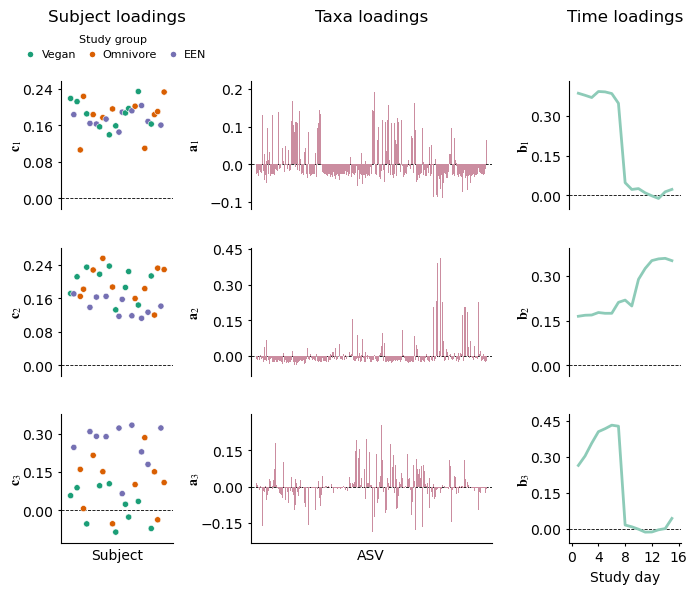

In [32]:
# Fig S7

# sign ambiguity
C[:,0] = C[:,0] * -1
A[:,0] = A[:,0] * -1

A[:,1] = A[:,1] * -1
B[:,1] = B[:,1] * -1

C[:,2] = C[:,2] * -1
A[:,2] = A[:,2] * -1


figS7 = factorplot([C,A,np.asarray(B)], var=strat_var, Metadata=Metadata, time_labels=time_labels, splines_on=False, nometa=False)
plt.show()
figS7.savefig("analysis_results/figures/FigS7.png", bbox_inches='tight', dpi=600)

## PARAFAC2, R=3

In [33]:
model_ = pd.read_pickle(fp+'/analysis_results/models/FARMM/parafac2/R3/best_run.pkl')
(C_par2,B_par2,A_par2) = model_.loc["factors"]

# component weights
print(la.norm(C_par2, axis=0))
# print(la.norm(C_par2, axis=0))
# permute to decreasing order of component weights
p = np.argsort(-la.norm(C_par2, axis=0))

C_par2 = C_par2[:,p]
C_par2 = C_par2 / la.norm(C_par2, axis=0)  # normalize C_par2
B_par2 = np.asarray(B_par2)[:,:,p]
A_par2 = A_par2[:,p]
print("Fit = ", get_model_fit(model_.loc['factors'], tensor, mask))

[0.37869791 0.55925015 0.40300818]
Fit =  50.96485206438881


In [34]:
## check convergence
# reconstruction_error = np.asarray([err for err in model_.loc["rec_errors"]]).reshape(-1,1)
# feasibility_gaps = np.asarray([err for err in model_.loc["feasibility_gaps"]])

# fig, axs = plt.subplots(1,4, figsize=(9,3))
# errs = np.hstack((reconstruction_error, feasibility_gaps))
# errs[np.where(errs[:,1] == 0),1] =  1e-10
# titles = ["relative reconstruction error", "parafac2 feasibility", "nonnegativity C feasibility", "GL feasibility"]
# for ix, ax in enumerate(range(errs.shape[1])):
#     axs[ix].semilogy(errs[:,ix], nonpositive='clip')
#     axs[ix].set_title(titles[ix])
#     if ix == 0:
#         axs[ix].set_ylim((0.2, 0.5))

# plt.tight_layout()
# axs[1].set_xlabel("iteration")
# plt.minorticks_off()
# plt.show()

### Scaled factorplot

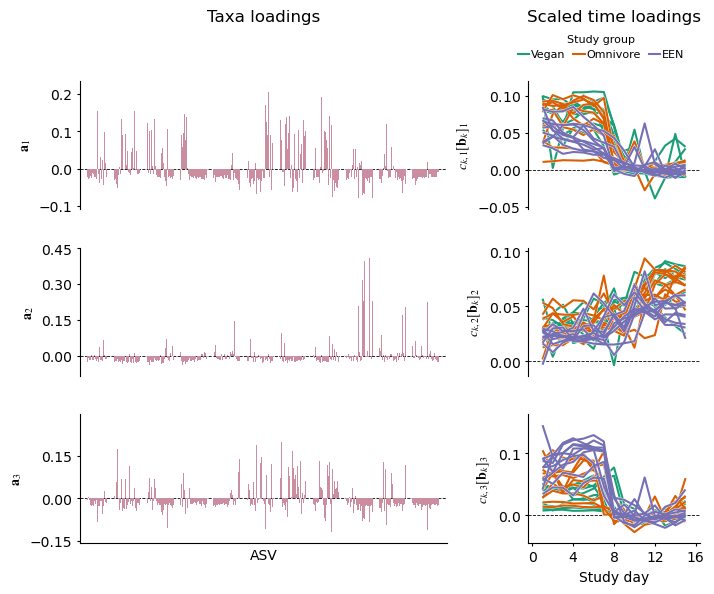

In [35]:
##  Fig S8

fig, axs = scaledfactorplot([C_par2,A_par2,B_par2], var=strat_var, Metadata=Metadata, time_labels=time_labels, splines_on=False)
plt.show()
fig.savefig("analysis_results/figures/FigS8.png", bbox_inches='tight', dpi=600)

In [36]:
##  assumptions for t-test satisfied? if not, use non-parametric test
component=0 # change component here
Metadata[str(component+1)] = C_par2[:,component] * -1

grouped = Metadata.groupby('Study group', observed=True)
samples = []
for name, group_df in grouped:
    print(f"Group: {name}")
    samples.append(group_df[str(component+1)].values)
    shapiro_stat, shapiro_p = stats.shapiro(group_df[str(component+1)].values)
    print(f"Shapiro-Wilk test for Sample {name}: p-value = {shapiro_p:.3f}")
levene_stat, levene_p = stats.levene(samples[0], samples[1], samples[2])
print(f"Levene's test for homogeneity of variance: p-value = {levene_p:.3f}")
# statisfied

Group: Vegan
Shapiro-Wilk test for Sample Vegan: p-value = 0.334
Group: Omnivore
Shapiro-Wilk test for Sample Omnivore: p-value = 0.200
Group: EEN
Shapiro-Wilk test for Sample EEN: p-value = 0.877
Levene's test for homogeneity of variance: p-value = 0.102


(3,) (3,)
(3,) (15, 3)


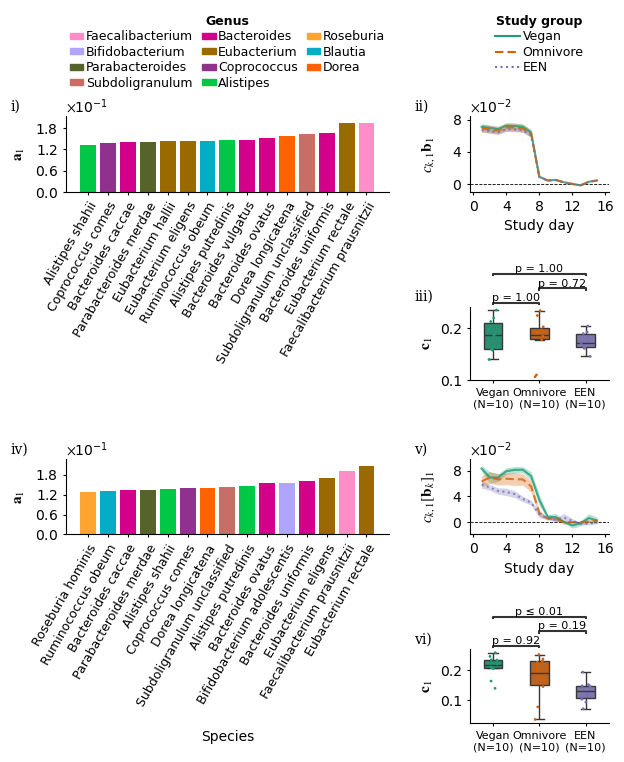

In [37]:
##  Fig 4

fig = plt.figure(figsize=mm2inch((178,200)))

gs = gridspec.GridSpec(2,1, figure=fig, hspace=0.3)
gs0 = gridspec.GridSpecFromSubplotSpec(2, 2, subplot_spec=gs[0], width_ratios=(0.7,0.3), height_ratios=(0.4,0.6), wspace=0.35, hspace=0.8)
gs1 = gridspec.GridSpecFromSubplotSpec(2, 2, subplot_spec=gs[1], width_ratios=(0.7,0.3), height_ratios=(0.4,0.6), wspace=0.35, hspace=0.8)

ax1 = fig.add_subplot(gs0[0, 0])
ax2 = fig.add_subplot(gs0[0, 1])
ax3 = fig.add_subplot(gs0[1, 1])

ax4 = fig.add_subplot(gs1[0, 0])
ax5 = fig.add_subplot(gs1[0, 1])
ax6 = fig.add_subplot(gs1[1, 1])

fnscaledcomponentplot(ax1,ax2,
                      [C,A,B], 
                      Metadata, Taxonomy, 1, 'Study group', 
                      time_labels=time_labels, individual=False, 
                      subtitle=False,labels=False, legend=True, legtitleheight=2.5, 
                      nspec=15,multcomptaxa=(1,1),Model2=[C_par2,A_par2,B_par2],tax_col=tax_colormap_farmm)
subjectsplotfarmm(ax3, [C,A,np.asarray(B)], Metadata, 1)


fnscaledcomponentplot(ax4,ax5,[C_par2,A_par2,B_par2], 
                      Metadata, Taxonomy, 1, 'Study group', 
                      time_labels=time_labels, individual=False, 
                      subtitle=False, labels=True, legend=False, legtitleheight=1.3,
                      nspec=15,tax_col=tax_colormap_farmm)
subjectsplotfarmm(ax6, [C_par2,A_par2,B_par2], Metadata, 1)

# panel labels
labels = ['i)', 'ii)', 'iii)', 'iv)', 'v)', 'vi)']
for ix, ax in enumerate([ax1, ax2, ax3, ax4, ax5, ax6]):
    ax.annotate(
        labels[ix],
        xy=(0, 1), xycoords='axes fraction',
        xytext=(-4, 0.2), textcoords='offset fontsize', fontsize='medium', va='bottom', fontfamily='serif')

for ax in [ax3, ax6]:
    ax.tick_params(axis = 'x', labelsize=8)
    box = ax.get_position()
    new_position = [box.x0, box.y0, box.width, box.height * 0.65]
    ax.set_position(new_position)

ax4.set_xlabel("Species", labelpad=15)
fig.savefig("analysis_results/figures/Fig4.png",dpi=600, bbox_inches='tight',pad_inches=0.03)

plt.show()

In [38]:
# ##  ALTERNATIVE Fig 4

# fig = plt.figure(figsize=mm2inch((240,120)))

# gs = gridspec.GridSpec(2,1, figure=fig, hspace=1.9)
# gs0 = gridspec.GridSpecFromSubplotSpec(1, 3, subplot_spec=gs[0], width_ratios=(0.25,0.5,0.25), wspace=0.35, hspace=0.8)
# gs1 = gridspec.GridSpecFromSubplotSpec(1, 3, subplot_spec=gs[1], width_ratios=(0.25,0.5,0.25), wspace=0.35, hspace=0.8)

# ax1 = fig.add_subplot(gs0[0, 1])
# ax2 = fig.add_subplot(gs0[0, 2])
# ax3 = fig.add_subplot(gs0[0, 0])

# ax4 = fig.add_subplot(gs1[0, 1])
# ax5 = fig.add_subplot(gs1[0, 2])
# ax6 = fig.add_subplot(gs1[0, 0])

# fnscaledcomponentplot(ax1,ax2,
#                       [C,A,B], 
#                       Metadata, Taxonomy, 1, 'Study group', 
#                       time_labels=time_labels, individual=False, 
#                       subtitle=False,labels=False, legend=True, legtitleheight=2.3, 
#                       nspec=15,multcomptaxa=(1,1),Model2=[C_par2,A_par2,B_par2],tax_col=tax_colormap_farmm)
# subjectsplotfarmm(ax3, [C,A,np.asarray(B)], Metadata, 1)


# fnscaledcomponentplot(ax4,ax5,[C_par2,A_par2,B_par2], 
#                       Metadata, Taxonomy, 1, 'Study group', 
#                       time_labels=time_labels, individual=False, 
#                       subtitle=False, labels=True, legend=False, legtitleheight=1.3,
#                       nspec=15,tax_col=tax_colormap_farmm)
# subjectsplotfarmm(ax6, [C_par2,A_par2,B_par2], Metadata, 1)

# # panel labels
# labels = ['i)', 'ii)', 'iii)', 'iv)', 'v)', 'vi)']
# for ix, ax in enumerate([ax1, ax2, ax3, ax4, ax5, ax6]):
#     ax.annotate(
#         labels[ix],
#         xy=(0, 1), xycoords='axes fraction',
#         xytext=(-4, 0.2), textcoords='offset fontsize', fontsize='medium', va='bottom', fontfamily='serif')

# for ax in [ax3, ax6]:
#     ax.tick_params(axis = 'x', labelsize=8)
#     box = ax.get_position()
#     new_position = [box.x0, box.y0, box.width, box.height * 0.65]
#     ax.set_position(new_position)

# ax4.set_xlabel("Species")
# # fig.savefig("analysis_results/figures/Fig4.png",dpi=600, bbox_inches='tight')

# plt.show()

(3,) (3,)
(3,) (15, 3)


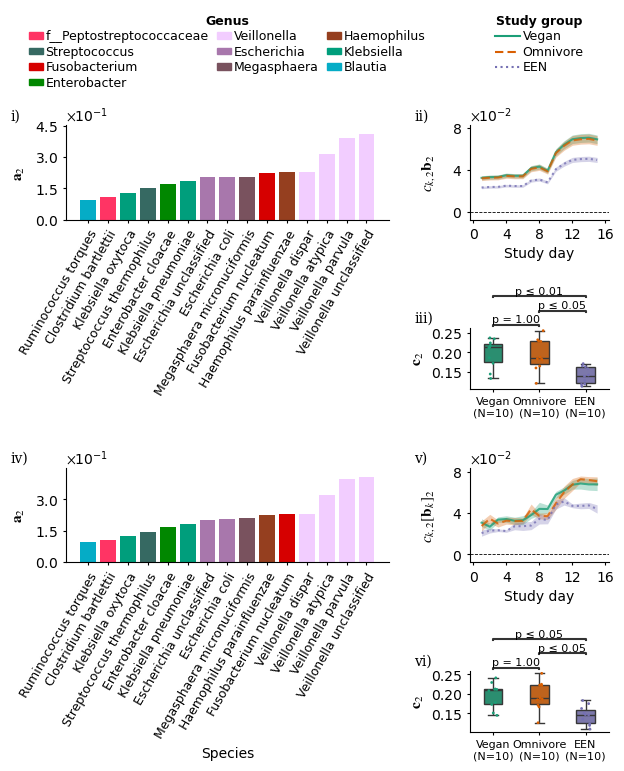

In [39]:
##  Fig S9

fig = plt.figure(figsize=mm2inch((178,200)))

gs = gridspec.GridSpec(2,1, figure=fig, hspace=0.3)
gs0 = gridspec.GridSpecFromSubplotSpec(2, 2, subplot_spec=gs[0], width_ratios=(0.7,0.3), wspace=0.35, hspace=0.8)
gs1 = gridspec.GridSpecFromSubplotSpec(2, 2, subplot_spec=gs[1], width_ratios=(0.7,0.3), wspace=0.35, hspace=0.8)

ax1 = fig.add_subplot(gs0[0, 0])
ax2 = fig.add_subplot(gs0[0, 1])
ax3 = fig.add_subplot(gs0[1, 1])

ax4 = fig.add_subplot(gs1[0, 0])
ax5 = fig.add_subplot(gs1[0, 1])
ax6 = fig.add_subplot(gs1[1, 1])

fnscaledcomponentplot(ax1,ax2,
                      [C,A,B], 
                      Metadata, Taxonomy, 2, 'Study group', 
                      time_labels=time_labels, individual=False, 
                      subtitle=False,labels=False, legend=True, legtitleheight=2.3, 
                      nspec=15,multcomptaxa=(2,2),Model2=[C_par2,A_par2,B_par2],tax_col=tax_colormap_farmm)
subjectsplotfarmm(ax3, [C,A,np.asarray(B)], Metadata, 2)


fnscaledcomponentplot(ax4,ax5,[C_par2,A_par2,B_par2], 
                      Metadata, Taxonomy, 2, 'Study group', 
                      time_labels=time_labels, individual=False, 
                      subtitle=False, labels=True, legend=False, legtitleheight=1.3,
                      nspec=15,tax_col=tax_colormap_farmm)
subjectsplotfarmm(ax6, [C_par2,A_par2,B_par2], Metadata, 2)

# panel labels
labels = ['i)', 'ii)', 'iii)', 'iv)', 'v)', 'vi)']
for ix, ax in enumerate([ax1, ax2, ax3, ax4, ax5, ax6]):
    ax.annotate(
        labels[ix],
        xy=(0, 1), xycoords='axes fraction',
        xytext=(-4, 0.2), textcoords='offset fontsize', fontsize='medium', va='bottom', fontfamily='serif')

for ax in [ax3, ax6]:
    ax.tick_params(axis = 'x', labelsize=8)
    box = ax.get_position()
    new_position = [box.x0, box.y0, box.width, box.height * 0.65]
    ax.set_position(new_position)

ax4.set_xlabel("Species")
plt.savefig("analysis_results/figures/FigS9.png",dpi=600, bbox_inches='tight',pad_inches=0.03)

plt.show()

(3,) (3,)
(3,) (15, 3)


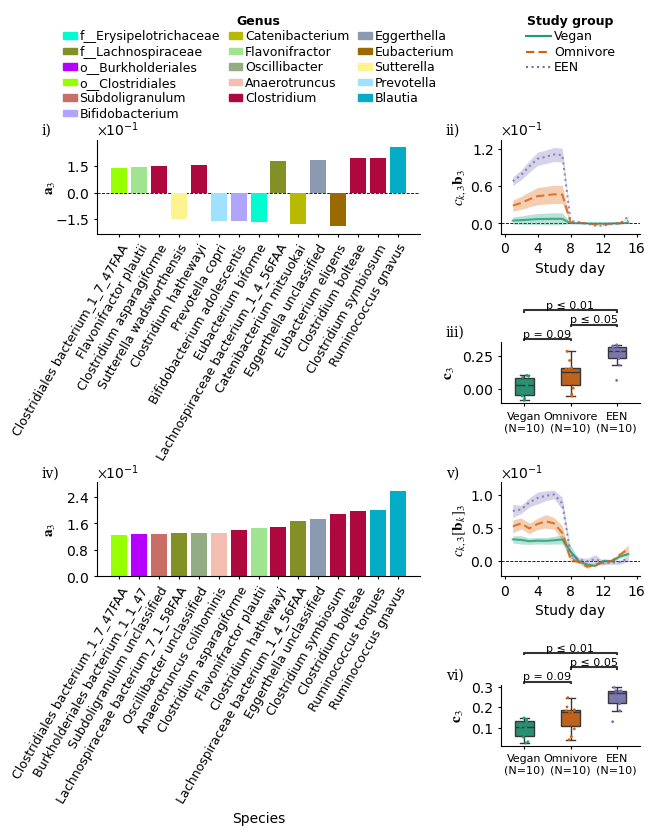

In [40]:
##  Fig S10

fig = plt.figure(figsize=mm2inch((178,200)))

gs = gridspec.GridSpec(2,1, figure=fig, hspace=0.3)
gs0 = gridspec.GridSpecFromSubplotSpec(2, 2, subplot_spec=gs[0], width_ratios=(0.7,0.3), wspace=0.35, hspace=0.8)
gs1 = gridspec.GridSpecFromSubplotSpec(2, 2, subplot_spec=gs[1], width_ratios=(0.7,0.3), wspace=0.35, hspace=0.8)

ax1 = fig.add_subplot(gs0[0, 0])
ax2 = fig.add_subplot(gs0[0, 1])
ax3 = fig.add_subplot(gs0[1, 1])

ax4 = fig.add_subplot(gs1[0, 0])
ax5 = fig.add_subplot(gs1[0, 1])
ax6 = fig.add_subplot(gs1[1, 1])

fnscaledcomponentplot(ax1,ax2,
                      [C,A,B], 
                      Metadata, Taxonomy, 3, 'Study group', 
                      time_labels=time_labels, individual=False, 
                      subtitle=False,labels=False, legend=True, legtitleheight=2.45, 
                      nspec=15,multcomptaxa=(3,3),Model2=[C_par2,A_par2,B_par2],tax_col=tax_colormap_farmm)
subjectsplotfarmm(ax3, [C,A,np.asarray(B)], Metadata, 3)


fnscaledcomponentplot(ax4,ax5,[C_par2,A_par2,B_par2], 
                      Metadata, Taxonomy, 3, 'Study group', 
                      time_labels=time_labels, individual=False, 
                      subtitle=False, labels=True, legend=False, legtitleheight=1.3,
                      nspec=15,tax_col=tax_colormap_farmm)
subjectsplotfarmm(ax6, [C_par2,A_par2,B_par2], Metadata, 3)

# panel labels
labels = ['i)', 'ii)', 'iii)', 'iv)', 'v)', 'vi)']
for ix, ax in enumerate([ax1, ax2, ax3, ax4, ax5, ax6]):
    ax.annotate(
        labels[ix],
        xy=(0, 1), xycoords='axes fraction',
        xytext=(-4, 0.2), textcoords='offset fontsize', fontsize='medium', va='bottom', fontfamily='serif')

for ax in [ax3, ax6]:
    ax.tick_params(axis = 'x', labelsize=8)
    box = ax.get_position()
    new_position = [box.x0, box.y0, box.width, box.height * 0.65]
    ax.set_position(new_position)

ax4.set_xlabel("Species")
plt.savefig("analysis_results/figures/FigS10.png",dpi=600, bbox_inches='tight',pad_inches=0.03)

plt.show()

## Comparison of CP and PARAFAC2 top 15 taxa

In [41]:
taxa_CP_1 = set(np.argpartition(abs(A[:,0]), -15)[-15:])
taxa_PAR2_1 = set(np.argpartition(abs(A_par2[:,0]), -15)[-15:])
taxa_CP_2 = set(np.argpartition(abs(A[:,1]), -15)[-15:])
taxa_PAR2_2 = set(np.argpartition(abs(A_par2[:,1]), -15)[-15:])
taxa_CP_3 = set(np.argpartition(abs(A[:,2]), -15)[-15:])
taxa_PAR2_3 = set(np.argpartition(abs(A_par2[:,2]), -15)[-15:])

print("percentage of overlapping taxa in the top 15 features\n" \
"component 1 = ", len(taxa_CP_1 & taxa_PAR2_1)/15 * 100)

print("percentage of overlapping taxa in the top 15 features\n" \
"component 2 = ", len(taxa_CP_2 & taxa_PAR2_2)/15 * 100)

print("percentage of overlapping taxa in the top 15 features\n" \
"component 3 = ", len(taxa_CP_3 & taxa_PAR2_3)/15 * 100)

taxa_CP = taxa_CP_1.union(taxa_CP_2).union(taxa_CP_3)
taxa_PAR2 = taxa_PAR2_1.union(taxa_PAR2_2).union(taxa_PAR2_3)

percentage of overlapping taxa in the top 15 features
component 1 =  86.66666666666667
percentage of overlapping taxa in the top 15 features
component 2 =  100.0
percentage of overlapping taxa in the top 15 features
component 3 =  60.0


In [42]:
## END